# Understanding the Attention Mechanism

This notebook will demystify the attention mechanism - the core innovation that makes BERT powerful.

## What You'll Learn:
1. Why attention is needed (the problem it solves)
2. How attention works mathematically
3. Scaled dot-product attention step-by-step
4. Multi-head attention and why it's useful
5. Visualizing attention patterns

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

# Set style for better visualizations - handle version compatibility
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid') 
    except OSError:
        plt.style.use('default')
        
np.random.seed(42)

## Part 1: Why Do We Need Attention?

Consider the sentence: "The cat sat on the mat because it was tired."

What does "it" refer to? The cat! But how does a model figure this out?

In [2]:
# Let's simulate word vectors for our sentence
words = ['The', 'cat', 'sat', 'on', 'the', 'mat', 'because', 'it', 'was', 'tired']
num_words = len(words)
hidden_dim = 4  # Small dimension for visualization

# Random word vectors (in reality, these come from embeddings)
word_vectors = np.random.randn(num_words, hidden_dim) * 0.5

# Let's manually make 'cat' and 'it' somewhat similar
word_vectors[1] = np.array([0.8, 0.2, -0.1, 0.5])  # 'cat'
word_vectors[7] = np.array([0.7, 0.3, -0.2, 0.4])  # 'it' (similar to cat)

print("Word vectors shape:", word_vectors.shape)
print("\nFirst few words and their vectors:")
for i in range(5):
    print(f"{words[i]:8s}: {word_vectors[i]}")

Word vectors shape: (10, 4)

First few words and their vectors:
The     : [ 0.24835708 -0.06913215  0.32384427  0.76151493]
cat     : [ 0.8  0.2 -0.1  0.5]
sat     : [-0.23473719  0.27128002 -0.23170885 -0.23286488]
on      : [ 0.12098114 -0.95664012 -0.86245892 -0.28114376]
the     : [-0.50641556  0.15712367 -0.45401204 -0.70615185]


## Part 2: The Attention Mechanism - Intuition

Attention answers: "When processing word X, how much should I look at word Y?"

The answer is based on similarity between words.

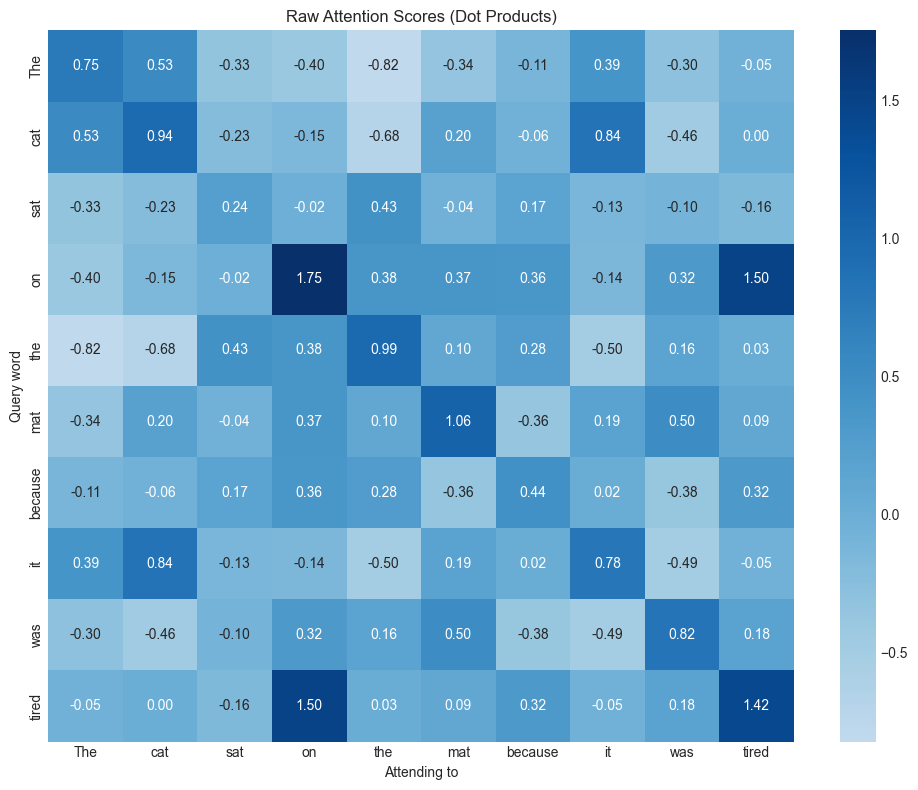

Notice: 'it' (row 7) has high score with 'cat' (column 1)!
This is how attention can resolve references.


In [3]:
# Let's compute how much each word should attend to each other word
# Using dot product as similarity measure

# Compute all pairwise dot products
attention_scores = word_vectors @ word_vectors.T  # [10, 10]

# Visualize the raw attention scores
plt.figure(figsize=(10, 8))
sns.heatmap(attention_scores, 
            xticklabels=words, 
            yticklabels=words, 
            cmap='Blues', 
            center=0,
            annot=True, 
            fmt='.2f')
plt.title('Raw Attention Scores (Dot Products)')
plt.xlabel('Attending to')
plt.ylabel('Query word')
plt.tight_layout()
plt.show()

print("Notice: 'it' (row 7) has high score with 'cat' (column 1)!")
print("This is how attention can resolve references.")

## Part 3: Scaled Dot-Product Attention

The full attention mechanism has three components:
1. **Query (Q)**: What information am I looking for?
2. **Key (K)**: What information do I have?
3. **Value (V)**: What information do I actually use?

Formula: `Attention(Q,K,V) = softmax(QK^T / √d_k)V`

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        Q: Query matrix [seq_len, d_k]
        K: Key matrix [seq_len, d_k]
        V: Value matrix [seq_len, d_k]
        mask: Optional mask for invalid positions
    
    Returns:
        output: Weighted sum of values [seq_len, d_k]
        attention_weights: Attention probabilities [seq_len, seq_len]
    """
    d_k = Q.shape[-1]
    
    # Step 1: Compute dot products between queries and keys
#       - Q @ K would give: [seq_len, d_k] @ [seq_len, d_k] = incompatible dimensions
#   - Q @ K.T gives: [seq_len, d_k] @ [d_k, seq_len] = [seq_len, seq_len] ✓
    scores = Q @ K.T  # [seq_len, seq_len]
    
    # Step 2: Scale by square root of dimension
    scores = scores / np.sqrt(d_k)
    
    # Step 3: Apply mask if provided (for padding, etc.)
    if mask is not None:
        scores = scores + mask * -1e9
    
    # Step 4: Apply softmax to get probabilities
    # Prevents overflow: Without this, np.exp(scores) can overflow to infinity for large scores
#       Example of the problem without stability:
#   scores = np.array([1000, 1001, 999])
#   np.exp(scores)  # Results in [inf, inf, inf] - overflow!

#   # With stability trick:
#   scores_stable = scores - np.max(scores)  # [-1, 0, -2]
#   np.exp(scores_stable)  # [0.368, 1.0, 0.135] - works!
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
#   Example:
#   exp_scores = [[2.0, 1.0, 0.5],   # Query 1's scores
#                 [1.0, 3.0, 2.0]]    # Query 2's scores

#   sums = [[3.5],    # Sum for query 1
#           [6.0]]    # Sum for query 2

#   attention_weights = [[2.0/3.5, 1.0/3.5, 0.5/3.5],  # [0.571, 0.286, 0.143]
#                        [1.0/6.0, 3.0/6.0, 2.0/6.0]]   # [0.167, 0.500, 0.333]

#   # Each row now sums to 1.0
    attention_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
    
    # Step 5: Weighted sum of values
#   # Values (information at each position)
#   V = [[1, 0],  # Word 1's value
#        [0, 1],  # Word 2's value
#        [1, 1]]  # Word 3's value

#   # Output for position 1: 0.7*[1,0] + 0.2*[0,1] + 0.1*[1,1] = [0.8, 0.3]
#   output = [[0.8, 0.3],
#             [0.5, 0.7],
#             [0.7, 0.9]]

#   Each output position becomes a context-aware representation that incorporates information from all positions it attended to.
    output = attention_weights @ V
    
    return output, attention_weights

# Let's use our word vectors as Q, K, V
Q = K = V = word_vectors
output, attention_weights = scaled_dot_product_attention(Q, K, V)

print("Input shape:", word_vectors.shape)
print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Input shape: (10, 4)
Output shape: (10, 4)
Attention weights shape: (10, 10)


### Visualizing Attention Weights

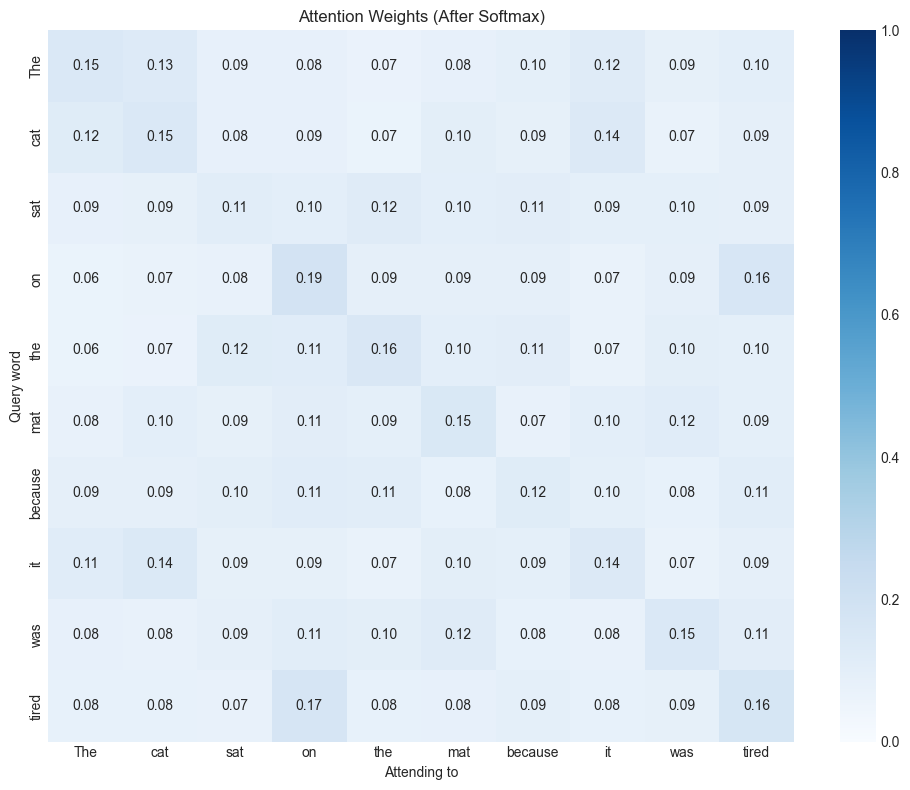

Each row sums to 1.0 (it's a probability distribution)
Sum of row 0: 1.000


In [5]:
# Visualize the attention weights after softmax
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, 
            xticklabels=words, 
            yticklabels=words, 
            cmap='Blues', 
            annot=True, 
            fmt='.2f',
            vmin=0, vmax=1)
plt.title('Attention Weights (After Softmax)')
plt.xlabel('Attending to')
plt.ylabel('Query word')
plt.tight_layout()
plt.show()

print("Each row sums to 1.0 (it's a probability distribution)")
print(f"Sum of row 0: {attention_weights[0].sum():.3f}")

### Understanding the Scaling Factor

Why do we divide by √d_k? Let's see what happens without it:

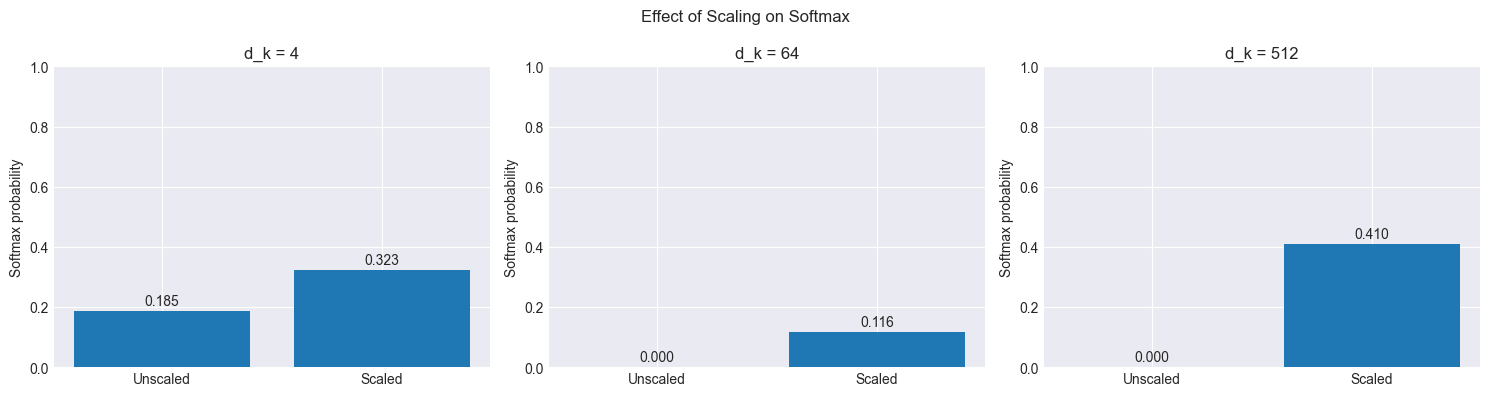

Without scaling, softmax becomes too 'sharp' (near 0 or 1) for large dimensions.
Scaling keeps gradients healthy!


In [6]:
# Compare with and without scaling
d_k_values = [4, 64, 512]  # Different dimensions

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, d_k in enumerate(d_k_values):
    # Create random vectors
    q = np.random.randn(d_k)
    k = np.random.randn(d_k)
    
    # Compute dot product
    dot_product = np.dot(q, k)
    scaled_dot = dot_product / np.sqrt(d_k)
    
    # Softmax of single value (compared to 0)
    scores = np.array([dot_product, 0])
    scaled_scores = np.array([scaled_dot, 0])
    
    softmax_unscaled = np.exp(scores) / np.exp(scores).sum()
    softmax_scaled = np.exp(scaled_scores) / np.exp(scaled_scores).sum()
    
    ax = axes[idx]
    x = ['Unscaled', 'Scaled']
    y = [softmax_unscaled[0], softmax_scaled[0]]
    ax.bar(x, y)
    ax.set_ylim(0, 1)
    ax.set_title(f'd_k = {d_k}')
    ax.set_ylabel('Softmax probability')
    
    # Add values on bars
    for i, v in enumerate(y):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.suptitle('Effect of Scaling on Softmax')
plt.tight_layout()
plt.show()

print("Without scaling, softmax becomes too 'sharp' (near 0 or 1) for large dimensions.")
print("Scaling keeps gradients healthy!")

## Part 4: Multi-Head Attention

Instead of one attention pattern, we use multiple 'heads' that can learn different relationships:
- Head 1: Syntactic dependencies (subject-verb)
- Head 2: Positional relationships (next word)
- Head 3: Semantic similarity
- Head 4: Long-range dependencies

In [ ]:
def multi_head_attention(X, num_heads, hidden_dim):
    """
    Simplified multi-head attention (without learned projections).
    """
    # Empirical finding: The original Transformer paper found that 8 heads of 64 dimensions each outperformed a single 512-dimensional head,      
#   despite having the same total capacity
# The final W_O projection recombines all heads back to full hidden_dim. info not lost
#   1. Non-linear combination advantage:
#   # Single large head (linear transformation):
#   attention_output = softmax(Q @ K.T) @ V  # One attention pattern

#   # Multi-head (non-linear due to separate softmaxes):
#   head1 = softmax(Q1 @ K1.T) @ V1  # Different attention pattern
#   head2 = softmax(Q2 @ K2.T) @ V2  # Different attention pattern
#   output = concat([head1, head2, ...]) @ W_O  # Combines diverse patterns
    seq_len = X.shape[0]
    head_dim = hidden_dim // num_heads
    
    # Split hidden dimension across heads
    X_heads = X.reshape(seq_len, num_heads, head_dim)
    
    all_outputs = []
    all_attention_weights = []
    
    # Process each head independently
    for head in range(num_heads):
        Q = K = V = X_heads[:, head, :]  # [seq_len, head_dim]
        output, attention_weights = scaled_dot_product_attention(Q, K, V)
        all_outputs.append(output)
        all_attention_weights.append(attention_weights)
    
    # Concatenate all heads
    concat_output = np.concatenate(all_outputs, axis=-1)
    
    return concat_output, all_attention_weights

# Create larger hidden dimension for multi-head
hidden_dim_large = 16
num_heads = 4
word_vectors_large = np.random.randn(num_words, hidden_dim_large) * 0.5

# Run multi-head attention
output_mh, attention_weights_mh = multi_head_attention(word_vectors_large, num_heads, hidden_dim_large)

print(f"Input shape: {word_vectors_large.shape}")
print(f"Output shape: {output_mh.shape}")
print(f"Number of attention heads: {len(attention_weights_mh)}")
print(f"Each head's attention shape: {attention_weights_mh[0].shape}")

Input shape: (10, 16)
Output shape: (10, 16)
Number of attention heads: 4
Each head's attention shape: (10, 10)


### Visualizing Different Attention Heads

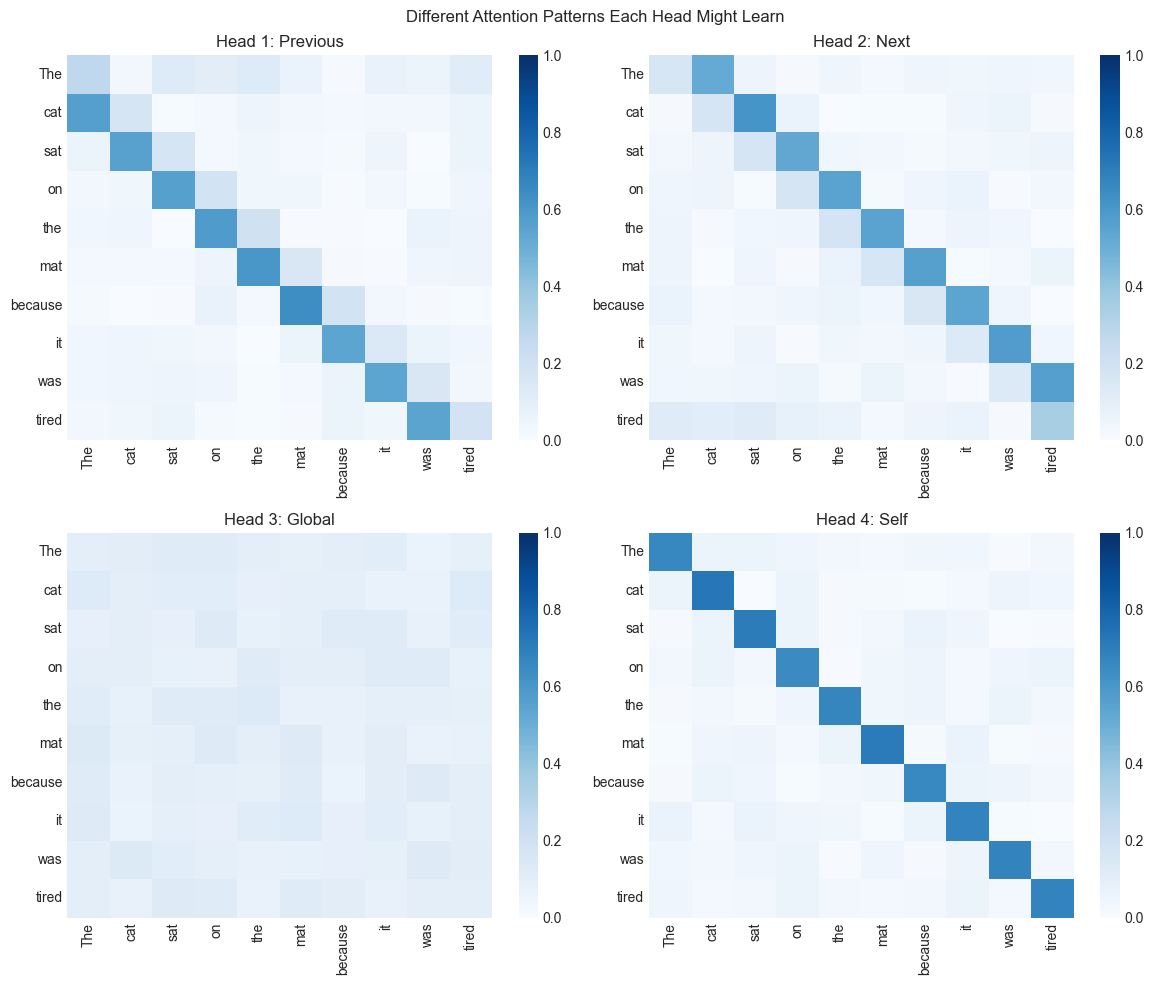

In [8]:
# Visualize what different heads might learn
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Simulate different attention patterns for each head
attention_patterns = [
    # Head 1: Attend to previous word
    np.eye(num_words, k=-1) * 0.8 + np.eye(num_words) * 0.2,
    # Head 2: Attend to next word  
    np.eye(num_words, k=1) * 0.8 + np.eye(num_words) * 0.2,
    # Head 3: Attend to first word (global context)
    np.zeros((num_words, num_words)) + 0.1,
    # Head 4: Self-attention (diagonal)
    np.eye(num_words)
]

# Add some noise and normalize
for i in range(4):
    pattern = attention_patterns[i] + np.random.rand(num_words, num_words) * 0.1
    # Normalize rows to sum to 1
    pattern = pattern / pattern.sum(axis=1, keepdims=True)
    
    sns.heatmap(pattern, 
                xticklabels=words, 
                yticklabels=words, 
                cmap='Blues',
                vmin=0, vmax=1,
                cbar=True,
                ax=axes[i])
    axes[i].set_title(f'Head {i+1}: {["Previous", "Next", "Global", "Self"][i]}')
    
plt.suptitle('Different Attention Patterns Each Head Might Learn')
plt.tight_layout()
plt.show()

## Part 5: Attention in Mini-BERT

Let's see how attention works in our actual Mini-BERT implementation:

In [ ]:
# Load Mini-BERT model and tokenizer for real attention analysis
from model import MiniBERT
from tokenizer import WordPieceTokenizer

# Load model and tokenizer
model = MiniBERT()
tokenizer = WordPieceTokenizer()
tokenizer.load_model('../tokenizer_8k.pkl')

# Process a sample sentence to get attention patterns
text = "The cat sat on the mat"
input_ids = tokenizer.encode(text)
input_ids_batch = np.array([input_ids])

# Forward pass to get attention patterns. required for the backward pass (gradient calculation).
#   3. Example - Matrix multiplication backward:
#   # Forward: output = Q @ K.T
#   # Backward needs:
#   grad_Q = grad_output @ K  # Need cached K
#   grad_K = grad_output.T @ Q  # Need cached Qw
#   cache = {
#       'embeddings': embedded_input,
#       'attention_outputs': [...],  # From each layer
#       'attention_weights': [...],  # Softmax results
#       'Q', 'K', 'V': [...],       # Projections
#       'scores': [...],            # Pre-softmax scores
#       'layer_outputs': [...],     # Each layer's output
#       'mlp_hidden': [...],        # FFN intermediate values
#       'pre_norm': [...],          # Values before layer norm
#       # etc.
#   }
logits, cache = model.forward(input_ids_batch)

print(f"Loaded Mini-BERT with {model.config.num_layers} layers and {model.config.num_attention_heads} heads")
print(f"Sample text: '{text}'")
print(f"Token IDs: {input_ids}")
print(f"Cache keys: {list(cache.keys())}")

Initialized Mini-BERT: 4,498,880 parameters (4.50M)
Tokenizer loaded from ../tokenizer_8k.pkl (799 tokens)
Loaded Mini-BERT with 3 layers and 4 heads
Sample text: 'The cat sat on the mat'
Token IDs: [2, 62, 50, 798, 45, 43, 62, 61, 43, 62, 57, 56, 62, 50, 798, 55, 43, 62, 3]
Cache keys: ['input_ids', 'attention_mask', 'token_emb', 'pos_emb', 'embeddings', 'layer_caches', 'final_hidden', 'final_ln_cache', 'logits']


In [10]:
# Extract attention weights from first layer (updated after bug fixes)
layer_caches = cache['layer_caches']
attention_layer_0 = layer_caches['layer_0']['attn_cache']['attention_weights']  # [batch, heads, seq_len, seq_len]
print(f"Attention shape: {attention_layer_0.shape}")
print(f"Batch size: {attention_layer_0.shape[0]}")
print(f"Number of heads: {attention_layer_0.shape[1]}")
print(f"Sequence length: {attention_layer_0.shape[2]}")

Attention shape: (1, 4, 19, 19)
Batch size: 1
Number of heads: 4
Sequence length: 19


### Visualizing Real Attention Patterns

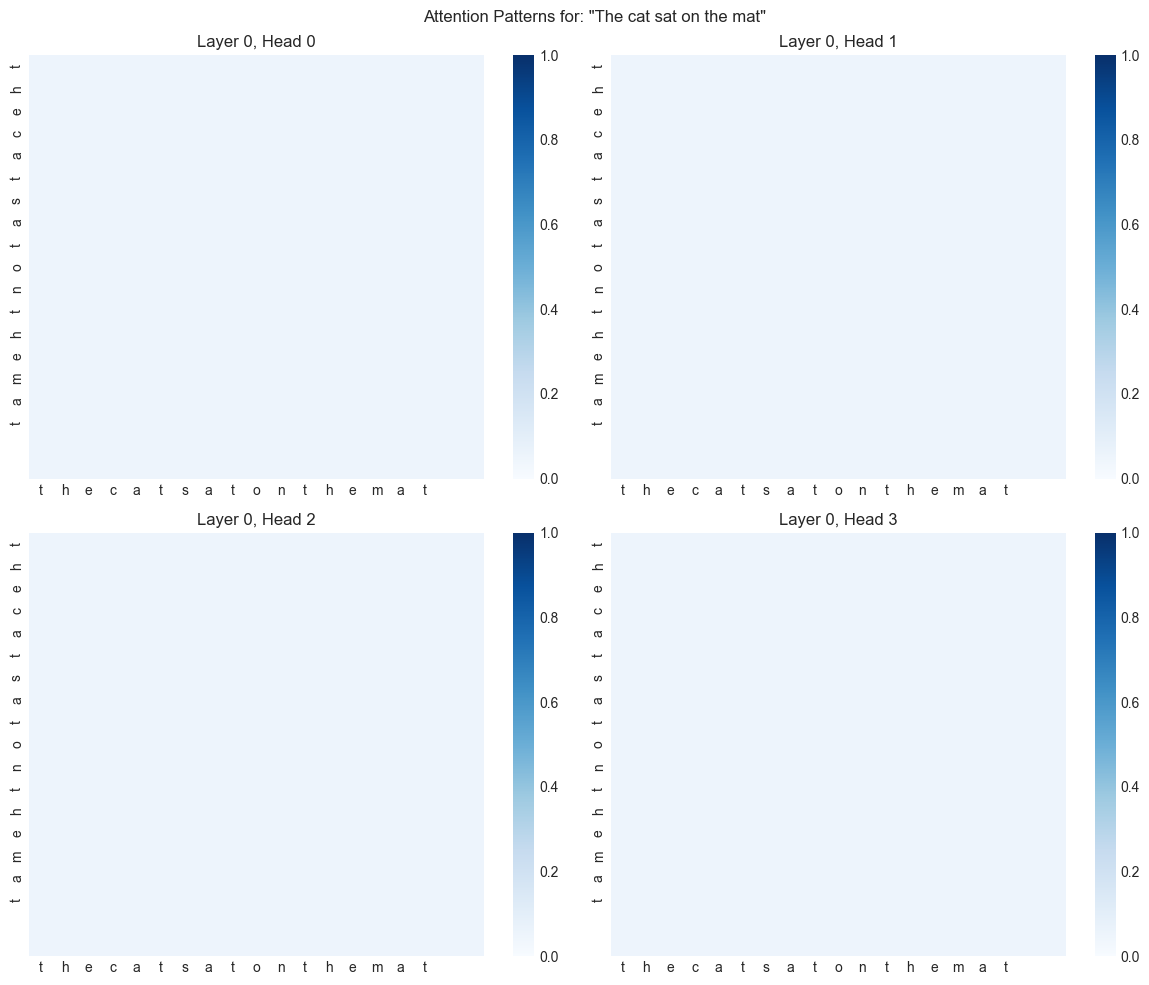

Each head learns different patterns!
This is from a randomly initialized model - patterns become more meaningful after training.


In [11]:
# Visualize attention from each head in layer 0
tokens = tokenizer.decode(input_ids).split()
batch_idx = 0

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for head_idx in range(4):
    attention = attention_layer_0[batch_idx, head_idx]
    
    sns.heatmap(attention,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap='Blues',
                vmin=0, vmax=1,
                cbar=True,
                ax=axes[head_idx])
    axes[head_idx].set_title(f'Layer 0, Head {head_idx}')
    
plt.suptitle(f'Attention Patterns for: "{text}"')
plt.tight_layout()
plt.show()

print("Each head learns different patterns!")
print("This is from a randomly initialized model - patterns become more meaningful after training.")

## Part 6: Interactive Attention Explorer

Let's create an interactive tool to explore how attention changes with different inputs:


Analyzing: 'The cat sat on the mat'


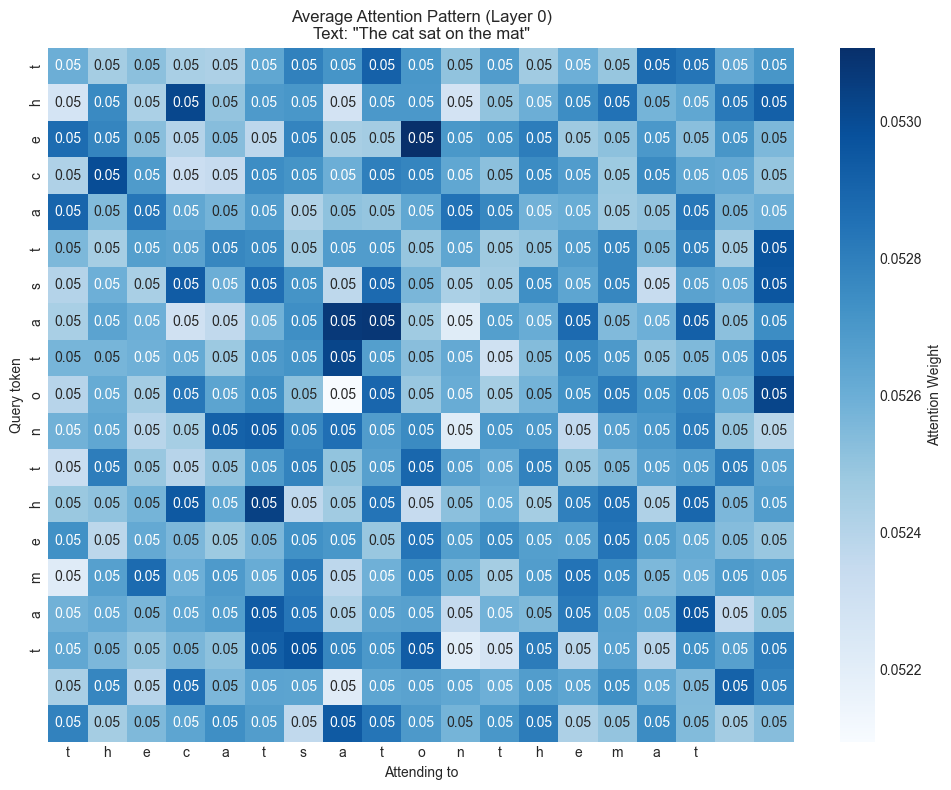


Analyzing: 'I love machine learning'


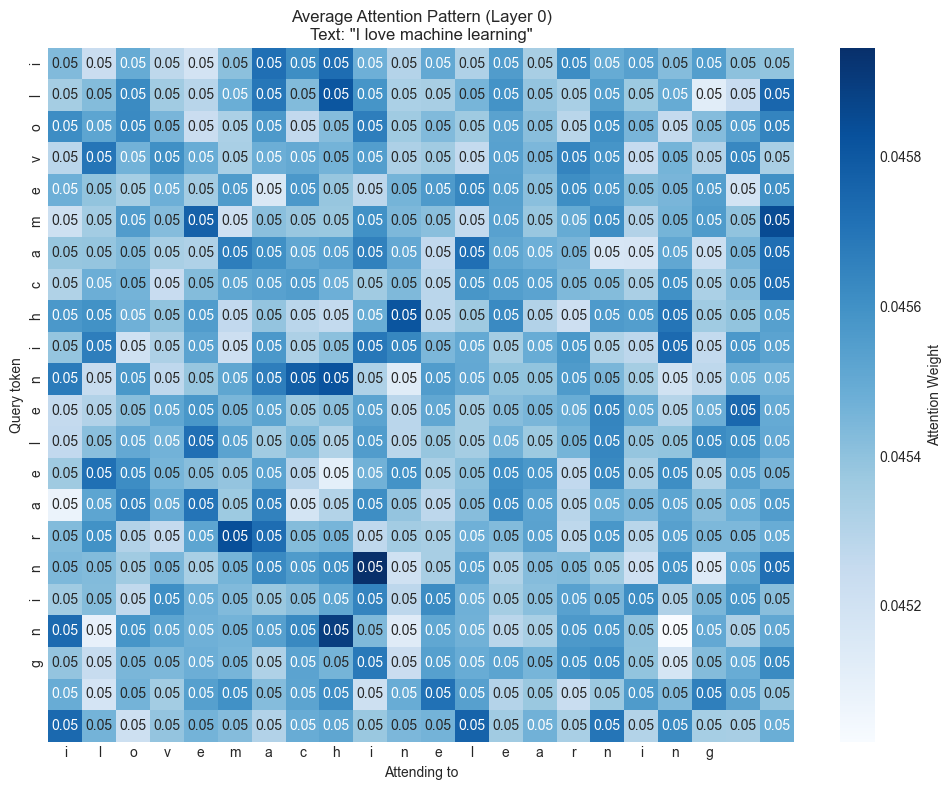


Analyzing: 'BERT is a transformer model'


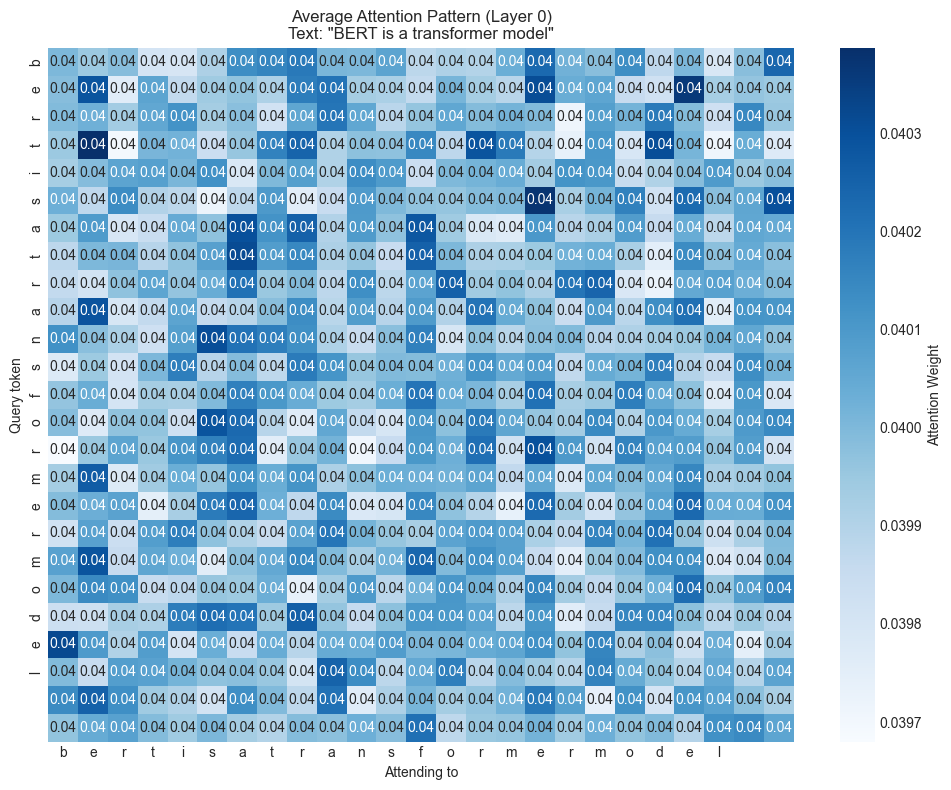

In [12]:
def explore_attention(text, model, tokenizer, layer=0):
    """
    Explore attention patterns for given text.
    """
    # Encode text
    input_ids = tokenizer.encode(text)
    input_ids_batch = np.array([input_ids])
    
    # Forward pass
    logits, cache = model.forward(input_ids_batch)
    
    # Get tokens
    tokens = tokenizer.decode(input_ids).split()
    
    # Get attention from specified layer (updated after bug fixes)
    layer_caches = cache['layer_caches']
    attention = layer_caches[f'layer_{layer}']['attn_cache']['attention_weights'][0]  # Remove batch dimension
    
    # Average attention across all heads
    avg_attention = attention.mean(axis=0)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_attention,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap='Blues',
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Attention Weight'})
    plt.title(f'Average Attention Pattern (Layer {layer})\nText: "{text}"')
    plt.xlabel('Attending to')
    plt.ylabel('Query token')
    plt.tight_layout()
    plt.show()
    
    return attention, tokens

# Try different sentences
test_sentences = [
    "The cat sat on the mat",
    "I love machine learning",
    "BERT is a transformer model"
]

for sentence in test_sentences:
    print(f"\nAnalyzing: '{sentence}'")
    attention, tokens = explore_attention(sentence, model, tokenizer, layer=0)

## Summary: Key Concepts

1. **Attention = Weighted Average**: Each word's representation becomes a weighted average of all words
2. **Weights from Similarity**: The weights come from how similar (dot product) words are
3. **Scaling Matters**: Dividing by √d_k keeps softmax gradients healthy
4. **Multiple Heads**: Different heads can learn different types of relationships
5. **Q, K, V**: Queries ask questions, Keys provide answers, Values are the actual information

### The Complete Attention Formula:
```
Attention(Q,K,V) = softmax(QK^T / √d_k)V
```

Where:
- Q = XW_Q (queries)
- K = XW_K (keys)  
- V = XW_V (values)
- W_Q, W_K, W_V are learned weight matrices

## Exercises

1. **Attention Without Scaling**: Remove the scaling factor and see what happens to the attention weights. Why does this cause problems?

2. **Custom Attention Patterns**: Create an attention pattern that always looks at the first and last word. How would you implement this?

3. **Head Specialization**: After training, different heads specialize. Can you think of 4 different patterns that would be useful for language understanding?

4. **Attention Masking**: How would you prevent the model from attending to padding tokens? Implement a simple mask.

In [13]:
# Space for your experiments
